### Initialisation

Here we set the google drive access, import the required libraries and load the dataset.

In [0]:
# This is to access google drive to load data
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
!pip install segyio

     |████████████████████████████████| 92kB 1.1MB/s 


In [0]:
import numpy as np
from scipy import stats
import pandas as pd
import tensorflow as tf

from random import randint
from numpy import argmax
import matplotlib

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy import stats

from keras import optimizers
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, ZeroPadding2D, BatchNormalization, Cropping2D
from keras.utils.np_utils import to_categorical
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage

from tqdm import tqdm
from tqdm import tqdm_notebook

import time

Using TensorFlow backend.


In [0]:
# load the SEGY seismic amplitudes and corresponding labels
!cp "/content/gdrive/My Drive/Forties/data/malenov/CNN_data/De_noised_Seismic___9_1562332244893.sgy" "De_noised_Seismic_cube_Forties___9_1561024414129.sgy"
!cp "/content/gdrive/My Drive/Forties/data/malenov/CNN_data/Por_Labels_1562331649850.sgy" "Por_Labels_1562324680441.sgy"

## Loading the Data
load seimic cube amplitudes and labels as numpy arrays named original_cube_amplitudes and original_cube_labels respectively.

In [0]:
import scipy.misc
import os
import segyio
import numpy as np
from shutil import copyfile

# Amplitudes
sgycube = 'De_noised_Seismic_cube_Forties___9_1561024414129.sgy'
# Labels
sgylabels = 'Por_Labels_1562324680441.sgy'

amplitude_inlines = []
with segyio.open(sgycube, "r") as segyfile:

    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()
    
    for inline in segyfile.ilines:
        amplitude_inlines.append(segyfile.iline[inline])

amplitude_inlines = np.array(amplitude_inlines)

# original cube amplitudes
# --- 
original_cube_amplitudes = np.copy(amplitude_inlines)
# ---

label_inlines = []
with segyio.open(sgylabels, "r") as segyfile:

    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()
    
    for inline in segyfile.ilines:
        label_inlines.append(segyfile.iline[inline])

label_inlines = np.array(label_inlines)

# original cube labels
# --- 
original_cube_labels = np.copy(label_inlines)
# --- 

# -----> Remove below for binary classification (this is an ad-hoc labelling for our dataset only)
# There were some NAN labels in the original labels (at the very bottom and top of the images)
# label NaNs in labels as either 1 or 5
# ---
for i in range(original_cube_labels.shape[0]):
    for k in range(original_cube_labels.shape[2]):
         
        if (k>230):
            original_cube_labels[i,:,k] = 5
        if (k<50):
            original_cube_labels[i,:,k] = 1
# ---

**Display Data**

In [0]:
def seismic_display(seismic_image, figsize = (14,8.75), grid = True, cmap = 'seismic', ticks = None): 
  plot_range_min1 = np.min(original_cube_amplitudes[0])
  plot_range_max1 = np.max(original_cube_amplitudes[0])
  norm1 = matplotlib.colors.Normalize(vmin=plot_range_min1, vmax=plot_range_max1)

  fig, ax = plt.subplots(figsize=figsize)
  im = plt.imshow(seismic_image.T, cmap=cmap)
  ax = plt.gca()
  if grid is True:
    ax.grid(color='black', linestyle='-', linewidth=0.5)
  plt.colorbar(im, ticks= ticks, spacing = 'uniform')

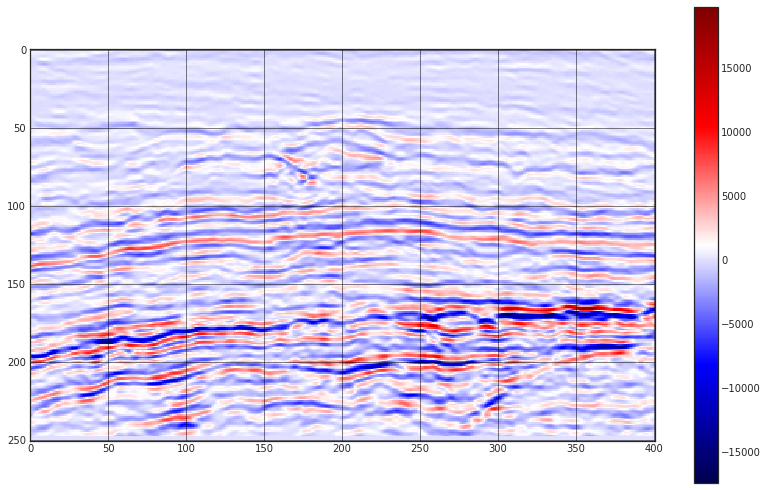

In [0]:
seismic_display(original_cube_amplitudes[0])

In [0]:
# convert cube to 4D (add 1 channel)
print("(number of inlines, x, y)")

print(original_cube_amplitudes.shape)
print(original_cube_labels.shape)

original_cube_amplitudes_4D =original_cube_amplitudes.reshape(401, 401, 251, 1)
original_cube_labels_4D = original_cube_labels.reshape(401, 401, 251, 1)

print(original_cube_amplitudes_4D.shape)
print(original_cube_labels_4D.shape)
print("labels in range: ", original_cube_labels.min(), "and ", original_cube_labels.max())

(number of inlines, x, y)
(401, 401, 251)
(401, 401, 251)
(401, 401, 251, 1)
(401, 401, 251, 1)
labels in range:  1.0 and  5.0


## Split to data to Training/Validation

Split into 320 to 81 training and validation sets (note that we dont use this for training, we use the 10 to 4 split below)

In [0]:
# Split data into trainindg and validation sets (320 samples for training 81 for validation)
X_train, X_val, y_train, y_val = train_test_split(original_cube_amplitudes_4D, original_cube_labels_4D, test_size=0.2, random_state=42)

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print("labels in range: ", y_train.min(), "and ", y_val.max())

(320, 401, 251, 1)
(320, 401, 251, 1)
(81, 401, 251, 1)
(81, 401, 251, 1)
labels in range:  1.0 and  5.0


Split into 10 to 4 training and validation sets and a test set

In [0]:
# This is to train with 10 inline slices only (inlines 0, 100, 200, 300, 400 and crossline 0, 100, 200, 300, 400)
X_train_3inlines_only = np.append(original_cube_amplitudes_4D[0:401:100,:,:,:],
                                  np.atleast_3d(original_cube_amplitudes_4D[:,0:1:1,:,:].reshape(1, 401, 251, 1)), axis = 0)
X_train_3inlines_only = np.append(X_train_3inlines_only,
                                  np.atleast_3d(original_cube_amplitudes_4D[:,100:101:1,:,:]).reshape(1, 401, 251, 1), axis = 0)
X_train_3inlines_only = np.append(X_train_3inlines_only,
                                  np.atleast_3d(original_cube_amplitudes_4D[:,200:201:1,:,:]).reshape(1, 401, 251, 1), axis = 0)
X_train_3inlines_only = np.append(X_train_3inlines_only,
                                  np.atleast_3d(original_cube_amplitudes_4D[:,300:301:1,:,:]).reshape(1, 401, 251, 1), axis = 0)
X_train_3inlines_only = np.append(X_train_3inlines_only,
                                  np.atleast_3d(original_cube_amplitudes_4D[:,400:401:1,:,:]).reshape(1, 401, 251, 1), axis = 0)


y_train_3inlines_only = np.append(original_cube_labels_4D[0:401:100,:,:,:],
                                  np.atleast_3d(original_cube_labels_4D[:,0:1:1,:,:].reshape(1, 401, 251, 1)), axis = 0)
y_train_3inlines_only = np.append(y_train_3inlines_only,
                                  np.atleast_3d(original_cube_labels_4D[:,100:101:1,:,:]).reshape(1, 401, 251, 1), axis = 0)
y_train_3inlines_only = np.append(y_train_3inlines_only,
                                  np.atleast_3d(original_cube_labels_4D[:,200:201:1,:,:]).reshape(1, 401, 251, 1), axis = 0)
y_train_3inlines_only = np.append(y_train_3inlines_only,
                                  np.atleast_3d(original_cube_labels_4D[:,300:301:1,:,:]).reshape(1, 401, 251, 1), axis = 0)
y_train_3inlines_only = np.append(y_train_3inlines_only,
                                  np.atleast_3d(original_cube_labels_4D[:,400:401:1,:,:]).reshape(1, 401, 251, 1), axis = 0)


X_val2_ax1 = original_cube_amplitudes_4D[60:360:200,:,:,:]
X_val2_ax2_1 = original_cube_amplitudes_4D[:,69:70:1,:,:]
X_val2_ax2_2 = original_cube_amplitudes_4D[:,360:361:1,:,:]
X_val2 = np.append(X_val2_ax1,
                   np.atleast_3d(X_val2_ax2_1.reshape(1, 401, 251, 1)), axis = 0)
X_val2 = np.append(X_val2,
                   np.atleast_3d(X_val2_ax2_2.reshape(1, 401, 251, 1)), axis = 0)

#y_val = [50:351:100]
y_val2_ax1 = original_cube_labels_4D[60:360:200,:,:,:]
y_val2_ax2_1 = original_cube_labels_4D[:,69:70:1,:,:]
y_val2_ax2_2 = original_cube_labels_4D[:,360:361:1,:,:]
y_val2 = np.append(y_val2_ax1,
                   np.atleast_3d(y_val2_ax2_1.reshape(1, 401, 251, 1)), axis = 0)
y_val2 = np.append(y_val2,
                   np.atleast_3d(y_val2_ax2_2.reshape(1, 401, 251, 1)), axis = 0)

#test set
X_test2 = original_cube_amplitudes_4D[81:91:1,:,:,:]
y_test2 = original_cube_labels_4D[81:91:1,:,:,:]

In [0]:
print(X_train_3inlines_only.shape)
print(y_train_3inlines_only.shape)
print(X_val2.shape)
print(y_val2.shape)
print(y_test2.shape)
print(y_test2.shape)

print("labels in range: ", y_train_3inlines_only.min(), "and ", y_val2.max())

(10, 401, 251, 1)
(10, 401, 251, 1)
(4, 401, 251, 1)
(4, 401, 251, 1)
(10, 401, 251, 1)
(10, 401, 251, 1)
labels in range:  1.0 and  5.0


Text(0.5, 0.98, 'Top Row: slices along inlines, Bottom Row: slices along crosslines ')

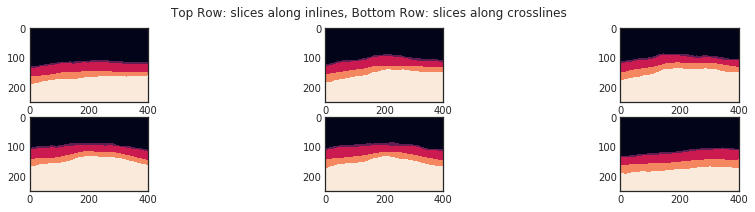

In [0]:
# plot training set labels
fig, axs = plt.subplots(2, 3, figsize=(15,3))
axs[0][0].imshow(y_train_3inlines_only[0].squeeze().T)
axs[0][1].imshow(y_train_3inlines_only[1].squeeze().T)
axs[0][2].imshow(y_train_3inlines_only[2].squeeze().T)

axs[1][0].imshow(y_train_3inlines_only[3].squeeze().T)
axs[1][1].imshow(y_train_3inlines_only[4].squeeze().T)
axs[1][2].imshow(y_train_3inlines_only[5].squeeze().T)
fig.suptitle("Top Row: slices along inlines, Bottom Row: slices along crosslines ")

## Data Augmentation
Do horizontal flip to increase the size of dataset by 2 fold.

In [0]:
# Vertical Flip
#X_train = np.append(X_train, [np.fliplr(y) for y in X_train], axis=0)
#y_train = np.append(y_train, [np.fliplr(y) for y in y_train], axis=0)

# Horizontal Flip
X_train = np.append(X_train, [np.flipud(y) for y in X_train], axis=0)
y_train = np.append(y_train, [np.flipud(y) for y in y_train], axis=0)

# Same Data Augmentation for the training set containing 10 inline slices only.
#X_train_3inlines_only = np.append(X_train_3inlines_only, [np.fliplr(y) for y in X_train_3inlines_only], axis=0)
#y_train_3inlines_only = np.append(y_train_3inlines_only, [np.fliplr(y) for y in y_train_3inlines_only], axis=0)
X_train_3inlines_only = np.append(X_train_3inlines_only, [np.flipud(y) for y in X_train_3inlines_only], axis=0)
y_trains              = np.append(y_train_3inlines_only, [np.flipud(y) for y in y_train_3inlines_only], axis=0)

print(X_train.shape)
print(y_train.shape)
print(X_train_3inlines_only.shape)
print(y_trains.shape)

(640, 401, 251, 1)
(640, 401, 251, 1)
(20, 401, 251, 1)
(20, 401, 251, 1)


Let's visualize our augmented dataset

Text(0.5, 0.98, 'First_row: original images, Second_row: augmented-images (after horizontal flip)')

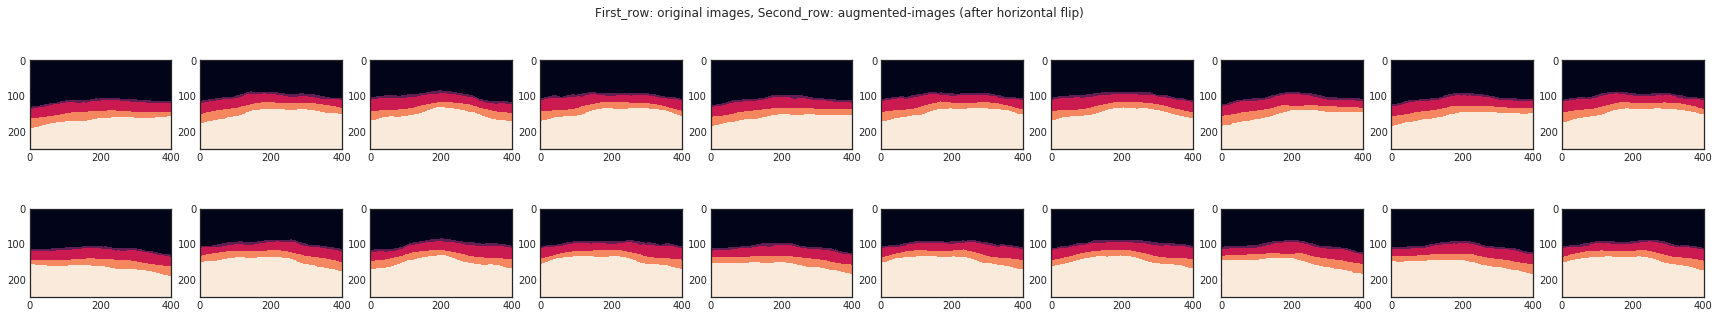

In [0]:
fig, axs = plt.subplots(2, 10, figsize=(30,5))
for i in range(10):
    axs[0][i].imshow(X_train[i].squeeze().T)
    axs[0][i].imshow(y_train[i].squeeze().T)
    axs[1][i].imshow(X_train[int(len(X_train)/2 + i)].squeeze().T)
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze().T)
    
fig.suptitle("First_row: original images, Second_row: augmented-images (after horizontal flip)")

## Model
Choose from one of the four models below (generally model 3 (U-Net) is the best model).

Few observations: 
-  Seismic data has depth, vertical flips deacrease accuracy. Only horizontal flips are used for data augmentation.
- The more channels a model has generally the better  (i.e.feature extraction seems to be very important for the prediction accuracy).
- e.g. for model 1: 16 channel -- 75%,  32 channel -- 89%, 48 channel -- 95% accuracy was obtained in 100 epochs.
- Model 2 and Model 3 get better than 99% training accuracy in 100 epochs of training (without any data augmentation when using the training set containing 80 samles).
- When using 10 inline slices for training, There is a 1% difference between validation/testing accuracy and training accuracy (slight overfitting). Adding dropout suprisingly result in even more overfitting.
-  U-Net (model 3) works better for small training datasets than model 2.
- U-Net (model 4)  is size invariant. Padding and fitter sizes are adjusted so that the size of the output kernel maps on the left handside mathces the size of the input on the right handside  of the U-Net, and would work for input images of any size (i.e. given any image will generate output segmentation map of the same size). Also, the user can specify the number of classes in their dataset, so this model is more general and applicable to any dataset. However, model 3 (assymetric U-Net with cropping in sideway connections) gives slightly higher  accuracy for our given dataset.

Model 1: A simple CNN model: 1-downsampling

In [0]:
img_size_target_x = 401
img_size_target_y = 251

def model1(input_layer, start_neurons):
    """A Simple encoder-decoder CNN model down sampling and up-sampling (gets 90% in 100 epoch)"""
  
    # Convolutional layyers (image size: 401x251)
    conv1 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(input_layer)
    conv2 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(conv1)
    
    # Max-Pool (Lower dimention: 401 --> 200, 251 --> 125)
    pool1 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(pool1)

    # Transposed convolution (Increase dimention: 200 --> 400, 125 --> 250)
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(conv3)
    
    # Convolutional Layer (f=2, p=2, s=1): 200 --> 201, 400 --> 401
    deconv4 = ZeroPadding2D(padding=(2, 2))(deconv4)
    conv5 = Conv2D(start_neurons * 1, (4, 4), activation="relu", padding="valid")(deconv4)
    
    output_layer = Conv2D(5, (1,1), padding="same", activation="softmax")(conv5)

    return output_layer

input_layer = Input((img_size_target_x, img_size_target_y, 1))
output_layer = model1(input_layer, 48)

Model 2: A simple CNN model: 2-downsampling 

In [0]:
img_size_target_x = 401
img_size_target_y = 251

def model2(input_layer, start_neurons):
    """A Simple encoder-decoder CNN model with 2 down sampling and 2 up-sampling"""
  
    # Convolutional layyers (image size: 401x251)
    conv1 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(input_layer)
    conv2 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(conv1)

    # Max-Pool (Lower dimention: 401 --> 200, 251 --> 125)
    pool1 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(start_neurons * 2, (5, 5), activation="relu", padding="same")(pool1)
    
    pool2 = MaxPooling2D((4, 4))(conv3)
    
    #middle
    conv4 = Conv2D(start_neurons * 8, (5, 5), activation="relu", padding="same")(pool2)
    conv4 = Conv2D(start_neurons * 8, (5, 5), activation="relu", padding="same")(conv4)


    # Transposed convolution (Increase dimention: 200 --> 400, 125 --> 250)
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(4, 4), padding="same")(conv4)
    
    # Convolutional Layer (f=2, p=2, s=1): 200 --> 201, 400 --> 401
    conv5_padding = ZeroPadding2D(padding=(2, 2))(deconv1)
    conv5 = Conv2D(start_neurons * 1, (4, 4), activation="relu", padding="valid")(conv5_padding)
    
    deconv2 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(conv5)
    
    conv6_padding = ZeroPadding2D(padding=(1, 2))(deconv2)
    conv6 = Conv2D(start_neurons * 1, (4, 4), activation="relu", padding="valid")(conv6_padding)
    
    output_layer = Conv2D(5, (1,1), padding="same", activation="softmax")(conv6)

    return output_layer

input_layer = Input((img_size_target_x, img_size_target_y, 1))
output_layer = model2(input_layer, 48)

Model 3: The U-Net Model: 4-downsampling (this is the best model).

In [0]:
img_size_target_x = 401
img_size_target_y = 251

# -----> if image size is not 401x251 adjust padding to get the same size output as input 
def model3(input_layer, start_neurons):
    """ A U-Net CNN model with 4 down sampling and 4 up-sampling similar to 
    O. Ronnenberg's U-Net model that won 2015 ISBI cell tracking challange."""
  
    # Convolutional layyers (image size: 401x251)
    conv1 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(input_layer)
    BatchNormalization1 =  BatchNormalization()(conv1)
    Drop1 = Dropout(0) (BatchNormalization1)
    conv2 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(Drop1)
    BatchNormalization2 =  BatchNormalization()(conv2)
    Drop2 = Dropout(0) (BatchNormalization2)
    
    # Max-Pool (Lower dimention: 401 --> 200, 251 --> 125)
    pool1 = MaxPooling2D((2, 2))(Drop2)
    
    # Convolutional layyers
    conv3_padding = ZeroPadding2D(padding=(2, 3))(pool1) # reflective may be better ?
    conv3 = Conv2D(start_neurons * 2, (5, 6), activation="relu", padding="valid")(conv3_padding)
    BatchNormalization3 =  BatchNormalization()(conv3)
    Drop3 = Dropout(0) (BatchNormalization3)
    conv4 = Conv2D(start_neurons * 2, (5, 5), activation="relu", padding="same")(Drop3)
    BatchNormalization4 =  BatchNormalization()(conv4)
    Drop4 = Dropout(0) (BatchNormalization4)

    # Max-Pool (Lower dimention: 200 --> 100, 125 --> 64)
    pool2 = MaxPooling2D((2, 2))(Drop4)
    
    # Convolutional layyers
    conv5_padding = ZeroPadding2D(padding=(2, 3))(pool2)
    conv5 = Conv2D(start_neurons * 3, (5, 6), activation="relu", padding="valid")(conv5_padding)
    BatchNormalization5 =  BatchNormalization()(conv5)
    Drop5 = Dropout(0) (BatchNormalization5)
    conv6 = Conv2D(start_neurons * 3, (5, 5), activation="relu", padding="same")(Drop5)
    BatchNormalization6 =  BatchNormalization()(conv6)
    Drop6 = Dropout(0) (BatchNormalization6)

    
    # Max-Pool (Lower dimention: 100 --> 50, 64 --> 32)
    pool3 = MaxPooling2D((2, 2))(Drop6)
    
    # Convolutional layyers
    conv7 = Conv2D(start_neurons * 4, (5, 5), activation="relu", padding="same")(pool3)
    BatchNormalization7 =  BatchNormalization()(conv7)
    Drop7 = Dropout(0) (BatchNormalization7)
    conv8 = Conv2D(start_neurons * 4, (5, 5), activation="relu", padding="same")(Drop7)
    BatchNormalization8 =  BatchNormalization()(conv8)
    Drop8 = Dropout(0) (BatchNormalization8)
    
    # Max-Pool (Lower dimention: 50 --> 25, 32 --> 16)
    pool4 = MaxPooling2D((2, 2))(Drop8)
    
    # Bottom of U-Net
    conv9 = Conv2D(start_neurons * 32, (5, 5), activation="relu", padding="same")(pool4)
    BatchNormalization9 =  BatchNormalization()(conv9)
    Drop9 = Dropout(0) (BatchNormalization9)
    conv10 = Conv2D(start_neurons * 32, (5, 5), activation="relu", padding="same")(Drop9)
    BatchNormalization10 =  BatchNormalization()(conv10)
    Drop10 = Dropout(0) (BatchNormalization10)
    
    # Transposed convolution1 (Increase dimention: 25 --> 50, 16 --> 32)
    deconv1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(Drop10)
    
    # Sideway connection of U-Net (these preserve spacial information to improve accuracy)
    deconv1 = concatenate([deconv1, conv8])

    # Convolutional layyers
    conv11 = Conv2D(start_neurons * 8, (5, 5), activation="relu", padding="same")(deconv1)
    BatchNormalization11 =  BatchNormalization()(conv11)
    Drop11 = Dropout(0) (BatchNormalization11)
    conv12 = Conv2D(start_neurons * 8, (5, 5), activation="relu", padding="same")(Drop11)
    BatchNormalization12 =  BatchNormalization()(conv12)
    Drop12 = Dropout(0) (BatchNormalization12)

    
    # Transposed convolution2 (Increase dimention: 50 --> 100, 32 --> 64)
    deconv2 = Conv2DTranspose(start_neurons * 7, (3, 3), strides=(2, 2), padding="same")(Drop12)
    
    # Sideway connection of U-Net (these preserve spacial information to improve accuracy)
    deconv2 = concatenate([deconv2, conv6])

    # Convolutional layyers
    conv13 = Conv2D(start_neurons * 4, (5, 5), activation="relu", padding="same")(deconv2)
    BatchNormalization13 =  BatchNormalization()(conv13)
    Drop13 = Dropout(0) (BatchNormalization13)
    conv14 = Conv2D(start_neurons * 4, (5, 5), activation="relu", padding="same")(Drop13)
    BatchNormalization14 =  BatchNormalization()(conv14)
    Drop14 = Dropout(0) (BatchNormalization14)

    
    # Transposed convolution3 (Increase dimention: 100 --> 200, 64 --> 128)
    deconv3 = Conv2DTranspose(start_neurons * 6, (3, 3), strides=(2, 2), padding="same")(Drop14)
    
    # Sideway connection of U-Net (these preserve spacial information to improve accuracy)
    conv4_padded = ZeroPadding2D(padding=(0, 1))(conv4) 
    deconv3 = concatenate([deconv3, conv4_padded])
    
    # Convolutional layyers
    conv15 = Conv2D(start_neurons * 2, (5, 5), activation="relu", padding="same")(deconv3)
    BatchNormalization15 =  BatchNormalization()(conv15)
    Drop15 = Dropout(0) (BatchNormalization15)

    conv16 = Conv2D(start_neurons * 2, (5, 5), activation="relu", padding="same")(Drop15)
    BatchNormalization16 =  BatchNormalization()(conv16)
    Drop16 = Dropout(0) (BatchNormalization16)

    # Transposed convolution4 (Increase dimention: 200 --> 400, 128 --> 256)
    deconv4 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(Drop16)
    
    # Sideway connection of U-Net (these preserve spacial information to improve accuracy)
    input_reshaped = Cropping2D(((0,1),(0,1)))(conv2) # input_layer can be changed to conv2.
    input_reshaped = ZeroPadding2D(padding=(0, 3))(input_reshaped)
    deconv4 = concatenate([deconv4, input_reshaped])

    
    # Convolutional layyers
    conv17_padding = ZeroPadding2D(padding=(4, 1))(deconv4)
    conv17 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="valid")(conv17_padding)
    BatchNormalization17 =  BatchNormalization()(conv17)
    Drop17 = Dropout(0) (BatchNormalization17)
    conv18 = Conv2D(start_neurons * 1, (4, 4), activation="relu", padding="valid")(Drop17)

    # Output
    output_layer = Conv2D(5, (1,1), padding="same", activation="softmax")(conv18)

    return output_layer

input_layer = Input((img_size_target_x, img_size_target_y, 1))
output_layer = model3(input_layer, 12)

W0828 12:39:58.590638 140180525930368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 12:39:58.638949 140180525930368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 12:39:58.648423 140180525930368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 12:39:58.685724 140180525930368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0828 12:39:58.686732 1401805259

Model 4: Size Invariant U-Net

In [0]:
img_size_target_x = 401
img_size_target_y = 251
number_of_classes = 5

# -----> if image size is not 401x251 adjust padding to get the same size output as input 
def model4(input_layer, start_neurons):
    """ A U-Net CNN model with 4 down sampling and 4 up-sampling similar to 
    O. Ronnenberg's U-Net model that won 2015 ISBI cell tracking challange."""
    
    # this is to make U-Net size invariant (always even dimentions for max-pooling)
    # ---
    i0 = 0; j0 = 0;
    if (input_layer.shape[1]%2 == 1): i0 = 1;
    if (input_layer.shape[2]%2 == 1): j0 = 1;
    # ---
    
    # Convolutional layers (image size: 401x251)
    conv1_padding = ZeroPadding2D(padding=(2+i0, 2+j0))(input_layer)
    conv1 = Conv2D(start_neurons * 1, (5+i0, 5+j0), activation="relu", padding="valid")(conv1_padding)
    BatchNormalization1 =  BatchNormalization()(conv1)
    Drop1 = Dropout(0) (BatchNormalization1)
    conv2 = Conv2D(start_neurons * 1, (5, 5), activation="relu", padding="same")(Drop1)
    BatchNormalization2 =  BatchNormalization()(conv2)
    Drop2 = Dropout(0) (BatchNormalization2)
    
    # Max-Pool (Lower dimention: 401 --> 200, 251 --> 125)
    pool1 = MaxPooling2D((2, 2))(Drop2)
  
    # this is to make U-Net size invariant (always even dimentions for max-pooling)
    # ---
    i1 = 0; j1 = 0;
    if (pool1.shape[1]%2 == 1): i1 = 1;
    if (pool1.shape[2]%2 == 1): j1 = 1;
    # ---


    # Convolutional layers
    conv3_padding = ZeroPadding2D(padding=(2+i1, 2+j1))(pool1) # reflective may be better ?
    conv3 = Conv2D(start_neurons * 2, (5+i1, 5+j1), activation="relu", padding="valid")(conv3_padding)
    BatchNormalization3 =  BatchNormalization()(conv3)
    Drop3 = Dropout(0) (BatchNormalization3)
    conv4 = Conv2D(start_neurons * 2, (5, 5), activation="relu", padding="same")(Drop3)
    BatchNormalization4 =  BatchNormalization()(conv4)
    Drop4 = Dropout(0) (BatchNormalization4)

    # Max-Pool (Lower dimention: 200 --> 100, 125 --> 64)
    pool2 = MaxPooling2D((2, 2))(Drop4)
    
    
    # this is to make U-Net size invariant (always even dimentions for max-pooling)
    # ---
    i2 = 0; j2 = 0;
    if (pool2.shape[1]%2 == 1): i2 = 1;
    if (pool2.shape[2]%2 == 1): j2 = 1;
    # ---
    
    
    # Convolutional layers
    conv5_padding = ZeroPadding2D(padding=(2+i2, 2+j2))(pool2)
    conv5 = Conv2D(start_neurons * 3, (5+i2, 5+j2), activation="relu", padding="valid")(conv5_padding)
    BatchNormalization5 =  BatchNormalization()(conv5)
    Drop5 = Dropout(0) (BatchNormalization5)
    conv6 = Conv2D(start_neurons * 3, (5, 5), activation="relu", padding="same")(Drop5)
    BatchNormalization6 =  BatchNormalization()(conv6)
    Drop6 = Dropout(0) (BatchNormalization6)

    
    # Max-Pool (Lower dimention: 100 --> 50, 64 --> 32)
    pool3 = MaxPooling2D((2, 2))(Drop6)
    
    
    # this is to make U-Net size invariant (always even dimentions for max-pooling)
    # ---
    i3 = 0; j3 = 0;
    if (pool3.shape[1]%2 == 1): i3 = 1;
    if (pool3.shape[2]%2 == 1): j3 = 1;
    # ---
    
    # Convolutional layyers
    conv7_padding = ZeroPadding2D(padding=(2+i3, 2+j3))(pool3)
    conv7 = Conv2D(start_neurons * 4, (5+i3, 5+j3), activation="relu", padding="valid")(conv7_padding)
    BatchNormalization7 =  BatchNormalization()(conv7)
    Drop7 = Dropout(0) (BatchNormalization7)
    conv8 = Conv2D(start_neurons * 4, (5, 5), activation="relu", padding="same")(Drop7)
    BatchNormalization8 =  BatchNormalization()(conv8)
    Drop8 = Dropout(0) (BatchNormalization8)
    
    # Max-Pool (Lower dimention: 50 --> 25, 32 --> 16)
    pool4 = MaxPooling2D((2, 2))(Drop8)
    
    
    # Bottom of U-Net
    conv9 = Conv2D(start_neurons * 32, (5, 5), activation="relu", padding="same")(pool4)
    BatchNormalization9 =  BatchNormalization()(conv9)
    Drop9 = Dropout(0) (BatchNormalization9)
    conv10 = Conv2D(start_neurons * 32, (5, 5), activation="relu", padding="same")(Drop9)
    BatchNormalization10 =  BatchNormalization()(conv10)
    Drop10 = Dropout(0) (BatchNormalization10)
    
    # Transposed convolution1 (Increase dimention: 25 --> 50, 16 --> 32)
    deconv1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(Drop10)
    
    # Sideway connection of U-Net (these preserve spacial information to improve accuracy)
    deconv1 = concatenate([deconv1, conv8])

    # Convolutional layers
    conv11_padding = ZeroPadding2D(padding=(2, 2))(deconv1)
    conv11 = Conv2D(start_neurons * 8, (5+i3, 5+j3), activation="relu", padding="valid")(conv11_padding)
    BatchNormalization11 =  BatchNormalization()(conv11)
    Drop11 = Dropout(0) (BatchNormalization11)
    conv12 = Conv2D(start_neurons * 8, (5, 5), activation="relu", padding="same")(Drop11)
    BatchNormalization12 =  BatchNormalization()(conv12)
    Drop12 = Dropout(0) (BatchNormalization12)

    
    # Transposed convolution2 (Increase dimention: 50 --> 100, 32 --> 64)
    deconv2 = Conv2DTranspose(start_neurons * 7, (3, 3), strides=(2, 2), padding="same")(Drop12)
    
    # Sideway connection of U-Net (these preserve spacial information to improve accuracy)
    deconv2 = concatenate([deconv2, conv6])

    # Convolutional layyers
    conv13_padding = ZeroPadding2D(padding=(2, 2))(deconv2)
    conv13 = Conv2D(start_neurons * 4, (5+i2, 5+j2), activation="relu", padding="valid")(conv13_padding)
    BatchNormalization13 =  BatchNormalization()(conv13)
    Drop13 = Dropout(0) (BatchNormalization13)
    conv14 = Conv2D(start_neurons * 4, (5, 5), activation="relu", padding="same")(Drop13)
    BatchNormalization14 =  BatchNormalization()(conv14)
    Drop14 = Dropout(0) (BatchNormalization14)

    
    # Transposed convolution3 (Increase dimention: 100 --> 200, 64 --> 128)
    deconv3 = Conv2DTranspose(start_neurons * 6, (3, 3), strides=(2, 2), padding="same")(Drop14)
    
    # Sideway connection of U-Net (these preserve spacial information to improve accuracy)
    deconv3 = concatenate([deconv3, conv4])
    
    # Convolutional layers
    conv15_padding = ZeroPadding2D(padding=(2, 2))(deconv3)
    conv15 = Conv2D(start_neurons * 2, (5+i1, 5+j1), activation="relu", padding="valid")(conv15_padding)
    BatchNormalization15 =  BatchNormalization()(conv15)
    Drop15 = Dropout(0) (BatchNormalization15)

    conv16 = Conv2D(start_neurons * 2, (5, 5), activation="relu", padding="same")(Drop15)
    BatchNormalization16 =  BatchNormalization()(conv16)
    Drop16 = Dropout(0) (BatchNormalization16)
    

    # Transposed convolution4 (Increase dimention: 200 --> 400, 128 --> 256)
    deconv4 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(Drop16)
    
    # Sideway connection of U-Net (these preserve spacial information to improve accuracy)
    deconv4 = concatenate([deconv4, conv2])

    
    # Convolutional layers
    conv17_padding = ZeroPadding2D(padding=(2, 2))(deconv4)
    conv17 = Conv2D(start_neurons * 1, (5+i0, 5+j0), activation="relu", padding="valid")(conv17_padding)
    BatchNormalization17 =  BatchNormalization()(conv17)
    Drop17 = Dropout(0) (BatchNormalization17)
    conv18 = Conv2D(start_neurons * 1, (4, 4), activation="relu", padding="same")(Drop17)

    # Output
    # -----> change 5 output channels to 1 for binary classification (e.g. 1 salt or 0 no salt)
    output_layer = Conv2D(number_of_classes, (1,1), padding="same", activation="softmax")(conv18)

    return output_layer

input_layer = Input((img_size_target_x, img_size_target_y, 1))
output_layer = model4(input_layer, 12)

W0809 10:05:36.504603 140252052981632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 10:05:36.550317 140252052981632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 10:05:36.562671 140252052981632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 10:05:36.613826 140252052981632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0809 10:05:36.615333 1402520529

In [0]:
model = Model(input_layer, output_layer)

In [0]:
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#adam = optimizers.Adam(lr=0.01, decay=1e-6)
#model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

W0828 12:40:10.757175 140180525930368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 401, 251, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 401, 251, 12) 312         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 401, 251, 12) 48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 401, 251, 12) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Training Model

first normalize the data (mean = 0 | std = 1)

In [0]:
def standardize(X_train, X_val, X_test, X_Cube, option=1):
  """
  X_train, X_val = training, validation sets respectively
  option=1: standardize such that mean = 0  std = 1
  option=2: standardize such that the range is between 0 and 255  
  """
  
  if (option==1):
    # standardize such that mean = 0  std = 1
    X_train_standard = (X_train - np.mean(X_train))/np.std(X_train)
    X_val_standard = (X_val - np.mean(X_train))/np.std(X_train)
    X_test_standard = (X_test - np.mean(X_train))/np.std(X_train)
    X_Cube_standard = (X_Cube - np.mean(X_train))/np.std(X_train)

  if (option==2):
    # standardize such that mean = 0  std = 1
    X_train_standard = (X_train - np.mean(original_cube_amplitudes_4D))/np.std(original_cube_amplitudes_4D)
    X_val_standard = (X_val - np.mean(original_cube_amplitudes_4D))/np.std(original_cube_amplitudes_4D)
    
  if (option==3):
    # standardize such that the range is between 0 and 255
    X_train_standard = 255*((X_train - np.mean(X_train))/(2*(np.amax(X_train)-np.amin(X_train))) + 0.5)
    X_val_standard = 255*((X_val - np.mean(X_train))/(2*(np.amax(X_train)-np.amin(X_train))) + 0.5)
    
  return (X_train_standard, X_val_standard, X_test_standard, X_Cube_standard)

In [0]:
print("--- Before Standardization ---")
print("train set mean is ", np.mean(X_train))
print("train set std is ", np.std(X_train))
print("validation set mean is ", np.mean(X_val))
print("validation set std is ", np.std(X_val))

#standardize (mean = 0 std = 1)
X_trains, X_vals, X_tests, X_Cube = standardize(X_train_3inlines_only, X_val2, X_test2, original_cube_amplitudes_4D)


print("--- After Standardization ---")
print("train set mean is ", np.mean(X_trains))
print("train set std is ", np.std(X_trains))
print("validation set mean is ", np.mean(X_vals))
print("validation set std is ", np.std(X_vals))

print("test set mean is ", np.mean(X_tests))
print("test set std is ", np.std(X_tests))
print("cube set mean is ", np.mean(X_Cube))
print("cube set std is ", np.std(X_Cube))

print(X_trains.shape)
print(X_vals.shape)

--- Before Standardization ---
train set mean is  0.16348086
train set std is  2460.1638
validation set mean is  0.5327026
validation set std is  2493.0405
--- After Standardization ---
train set mean is  -1.1837667e-08
train set std is  0.99999994
validation set mean is  0.0015737335
validation set std is  1.0247562
test set mean is  0.0013396483
test set std is  1.0431838
cube set mean is  0.00042145065
cube set std is  1.010245
(20, 401, 251, 1)
(4, 401, 251, 1)


**Train the Model**

In [0]:
number_of_classes = 5
early_stopping = EarlyStopping(patience=150, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
#model_checkpoint = ModelCheckpoint("/content/gdrive/My Drive/FCN Approach/Models/Unet | 4ds/keras.model3_epoch50_batchsize10_#inlines12_Date11072019", save_best_only=True, verbose=1)

# if validation accuracy does not improve in 20 epochs reduce the learning rate by a factor of 10 (star lr is 0.001)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=100, min_lr=0.00001, verbose=1)

# Desired data augmentations (None of the below help for the Forties dataset)
datagen = ImageDataGenerator()
    #fill_mode = "reflect")
    #brightness_range=(0, 1),
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #rotation_range=(5),
    #width_shift_range=0.05,
    #height_shift_range=0.05,
    #zoom_range=0.01)
    #shear_range=0.15,
    #horizontal_flip=True)

epochs = 40
batch_size = 4

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# put weight to the loss of for each label (this is used if some labels a are better predicted than others)
# class_weight='auto' sets these weights to the reciprocal of label proportion
sample_weight = {0: 1.,
                1: 10.,
                2: 3.,
                3: 3.,
                4: 1. }
# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(X_trains, to_categorical(y_trains-1, num_classes=number_of_classes), batch_size=batch_size),
                    class_weight='auto',
                    validation_data=[X_vals, to_categorical(y_val2-1, num_classes=number_of_classes)],
                    steps_per_epoch=len(X_trains)/(batch_size), epochs=epochs,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

W0828 12:40:25.419142 140180525930368 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
5/5 [==============================] - 10s 2s/step - loss: 1.6021 - acc: 0.2882 - val_loss: 3.9958 - val_acc: 0.3066

Epoch 00001: val_loss improved from inf to 3.99578, saving model to ./keras.model
Epoch 2/40
5/5 [==============================] - 1s 163ms/step - loss: 1.0467 - acc: 0.5391 - val_loss: 1.0109 - val_acc: 0.5679

Epoch 00002: val_loss improved from 3.99578 to 1.01088, saving model to ./keras.model
Epoch 3/40
5/5 [==============================] - 1s 146ms/step - loss: 0.6749 - acc: 0.6624 - val_loss: 0.6628 - val_acc: 0.7604

Epoch 00003: val_loss improved from 1.01088 to 0.66276, saving model to ./keras.model
Epoch 4/40
5/5 [==============================] - 1s 145ms/step - loss: 0.4304 - acc: 0.8737 - val_loss: 0.4601 - val_acc: 0.8964

Epoch 00004: val_loss improved from 0.66276 to 0.46015, saving model to ./keras.model
Epoch 5/40
5/5 [==============================] - 1s 146ms/step - loss: 0.2617 - acc: 0.9410 - val_loss: 0.4269 - val_acc: 0.9411

Epoch 0

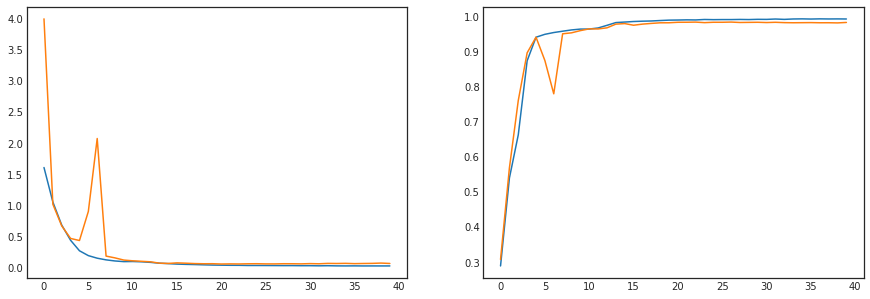

In [0]:
# Plot Accuracy and Loss wrt number of epochs
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

## Original Mask vs Predicted Mask

In [0]:
def test_accuracy_score(prediction, actual_labels):
  "plots accuracy of each label and the overall accuracy"
  if (prediction.shape[0:3] != actual_labels.shape[0:3]): print("shape of inputs do not match"); return 0;
  
  # Pixelwise accuracy score
  Num0=0; Num1=0; Num2=0; Num3=0; Num4=0;
  error0=0; error1=0; error2=0; error3=0; error4=0;
  for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
      for k in range(prediction.shape[2]):
        if actual_labels[i,j,k] == 0:
          Num0 += 1
          if (actual_labels[i,j,k] != prediction[i,j,k]): error0 += 1;
        
        if actual_labels[i,j,k,0] == 1:
          Num1 += 1
          if (actual_labels[i,j,k,0] != prediction[i,j,k]): error1 += 1;
        
        if actual_labels[i,j,k,0] == 2: 
          Num2 += 1
          if (actual_labels[i,j,k,0] != prediction[i,j,k]): error2 += 1;
         
        if actual_labels[i,j,k,0] == 3:
          Num3 += 1
          if (actual_labels[i,j,k,0] != prediction[i,j,k]): error3 += 1;
        
        if actual_labels[i,j,k,0] == 4:
          Num4 += 1
          if (actual_labels[i,j,k,0] != prediction[i,j,k]): error4 += 1;
  
  total_error = error0 + error1 + error2 + error3 + error4
  percentage_error = total_error/(prediction.shape[0]*prediction.shape[1]*prediction.shape[2])
  Overall_accuracy = 1 - percentage_error
  label0_accuracy  = 1 - error0/Num0
  label1_accuracy  = 1 - error1/Num1
  label2_accuracy  = 1 - error2/Num2
  label3_accuracy  = 1 - error3/Num3
  label4_accuracy  = 1 - error4/Num4
  
  # All the plots
  fig = plt.figure(figsize=(16, 2))
  #plt.subplot(321)
  plt.ylim(0.75, 1)
  plt.bar(["overall", "label0", "label1", "label2", "label3", "label4"], [Overall_accuracy, label0_accuracy, label1_accuracy, label2_accuracy, label3_accuracy, label4_accuracy], align='center')
  plt.ylabel("Accuracy")
  fig = plt.figure(figsize=(10, 60))
  fig.tight_layout()
  
  print ("overall accuracy is ", Overall_accuracy)
  print ("label0 accuracy is " , label0_accuracy)
  print ("label1 accuracy is " , label1_accuracy)
  print ("label2 accuracy is " , label2_accuracy)
  print ("label3 accuracy is " , label3_accuracy)
  print ("label4 accuracy is " , label4_accuracy)
  
  return [Overall_accuracy, label0_accuracy, label1_accuracy, label2_accuracy, label3_accuracy, label4_accuracy]


#iou error
def iou_accuracy(prediction, actual_labels):
  with tf.Session() as sess:
      ypredT = tf.constant(prediction)
      ytrueT = tf.constant(actual_labels)
      iou,conf_mat = tf.metrics.mean_iou(ytrueT, ypredT, num_classes=5)
      sess.run(tf.local_variables_initializer())
      sess.run([conf_mat])
      miou = sess.run([iou])
      print(miou)

**Investigations with the validation set**

In [0]:
# Load trained model
model = load_model("./keras.model")

# Load trained model saved on drive
#model = load_model("/content/gdrive/My Drive/FCN Approach/Models/Unet | 4ds/best_keras.model")
#model1 = load_model("/content/gdrive/My Drive/FCN Approach/Models/Unet | 4ds/09835_keras_no_depth.model")

# Load Autoencoder Model
# model = load_model("./autokeras.model")
#model.save("/content/gdrive/My Drive/FCN Approach/Models/Unet | 4ds/09835_keras_no_depth.model")

In [0]:
# 99% model
# model = load_model("/content/gdrive/My Drive/FCN Approach/Models/Simple CNN | 1ds/keras.model1_150_epochs")
start = time.time()
prediction_validation = argmax(model.predict(X_vals), axis = 3)
end = time.time()
print('execution_time: ', end - start, 'seconds')

execution_time:  0.08274221420288086 seconds


overall accuracy is  0.9835818819485151
label0 accuracy is  0.9988926458657792
label1 accuracy is  0.9302325581395349
label2 accuracy is  0.9383178467670292
label3 accuracy is  0.9194119160983143
label4 accuracy is  0.9956389385216068


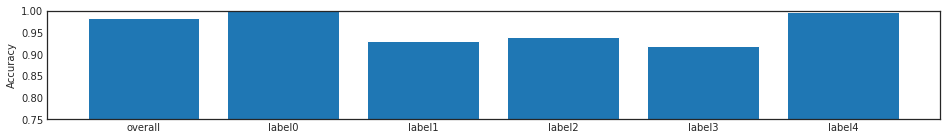

<Figure size 720x4320 with 0 Axes>

In [0]:
validation_accuracy = test_accuracy_score(prediction_validation, y_val2-1)

*Plots of the actual masks vs the predicted mask in the validation set*

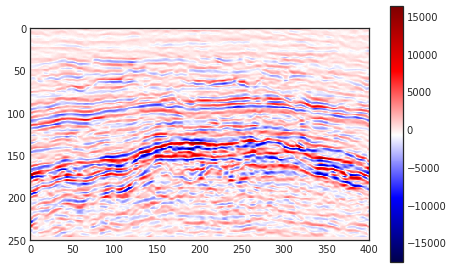

In [0]:
# Seismic Image
seismic_display(X_val2[1, :, :, 0], figsize= (7.6,4.7), grid = False)

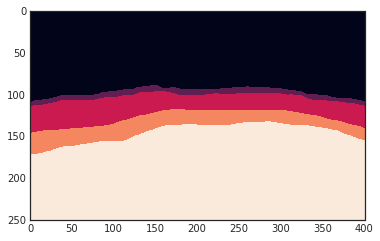

In [0]:
# Ground truth Mask
plt.imshow(y_val2[1, :, :, 0].T)

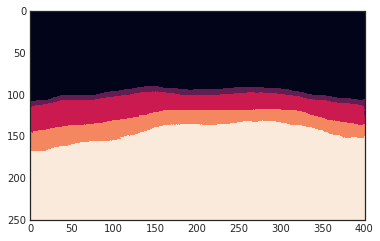

In [0]:
# Predicted Mask
# plt.imshow(prediction_validation[1].T)
plt.imshow(prediction_validation[1].T)

In [0]:
# This is to spare memory so the session doesn't crash
del prediction_validation

**Investigations with the test set**

In [0]:
prediction_test = argmax(model.predict(X_tests), axis = 3)

overall accuracy is  0.9881978321129448
label0 accuracy is  0.9979772368585077
label1 accuracy is  0.9403370152382489
label2 accuracy is  0.9590417384189445
label3 accuracy is  0.93766366481446
label4 accuracy is  0.9990513223869157


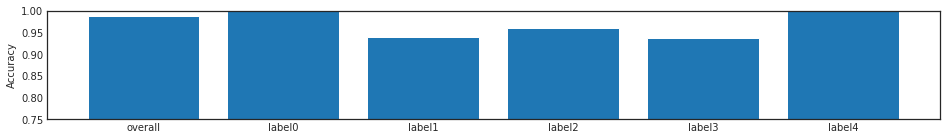

<Figure size 720x4320 with 0 Axes>

In [0]:
test_accuracy = test_accuracy_score(prediction_test, y_test2-1)

Above it was observed that the test accuracies are very similar to the validation accuracies.

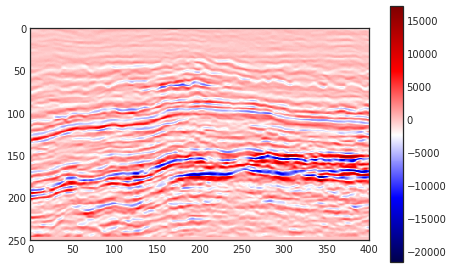

In [0]:
# Seismic Image
seismic_display(X_test2[0, :, :, 0], figsize= (7.6,4.7), grid = False)

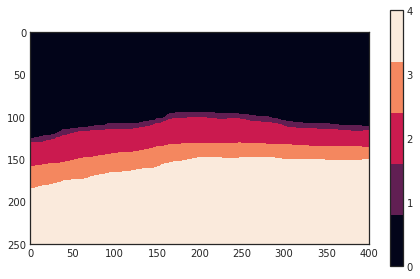

In [0]:
# Ground Truth Mask
seismic_display(y_test2[0, :, :, 0]-1, figsize= (7.6,4.7), grid = False, cmap = plt.cm.get_cmap(None, 5), ticks = np.linspace(0,4,5))

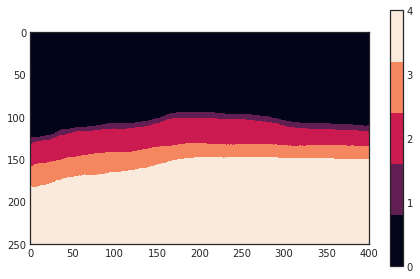

In [0]:
# Predicted Mask
seismic_display(prediction_test[0], figsize= (7.6,4.7), grid = False, cmap = plt.cm.get_cmap(None, 5), ticks = np.linspace(0,4,5))

In [0]:
# This is to spare memory so the session doesn't crash
del prediction_test

## Predict the Entire Volume 

In [0]:
start = time.time()
prediction_cube = argmax(model.predict(X_Cube), axis = 3)
end = time.time()
print('execution_time: ', end - start)

prediction_cube.shape
#X_vals.shape
#original_cube_amplitudes_4D.shape

execution_time:  9.844111442565918


(401, 401, 251)

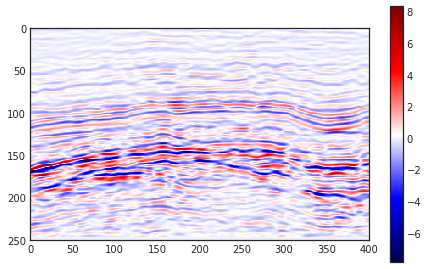

In [0]:
# Seismic Image
seismic_display(X_Cube[:, 330, :, 0], figsize= (7.6,4.7), grid = False)

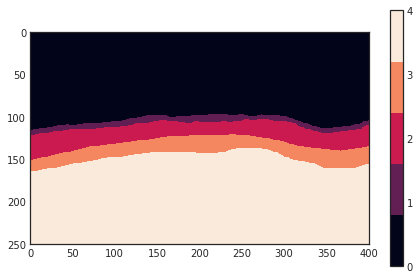

In [0]:
# Ground truth segmentation map of crossline slice 330
seismic_display(original_cube_labels_4D[:, 330, :, 0]-1, figsize= (7.6,4.7), grid = False, cmap = plt.cm.get_cmap(None, 5), ticks = np.linspace(0,4,5))

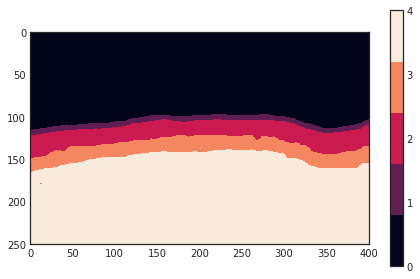

In [0]:
# predicted segmentation map for crossline slice 330
seismic_display(prediction_cube[:, 330, :], figsize= (7.6,4.7), grid = False, cmap = plt.cm.get_cmap(None, 5), ticks = np.linspace(0,4,5))


overall accuracy is  0.9848420944241516
label0 accuracy is  0.99829240818769
label1 accuracy is  0.9102152307047758
label2 accuracy is  0.9443867184751571
label3 accuracy is  0.9270092016279803
label4 accuracy is  0.9979193350463809


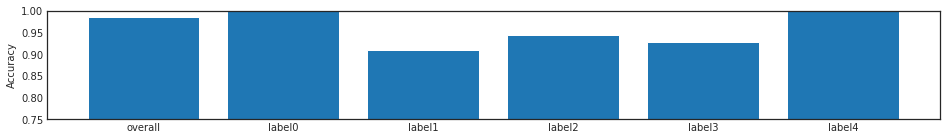

<Figure size 720x4320 with 0 Axes>

In [0]:
# pixelwise accuracy
test_accuracy = test_accuracy_score(prediction_cube, original_cube_labels_4D-1)

In [0]:
# iou-accuracy
iou_accuracy(prediction_cube, original_cube_labels_4D[:,:,:,0]-1)

[0.922468]


In [0]:
# save predictions
#np.save('/content/gdrive/My Drive/predicted_volume_beforeModelAverage_beforeCRF.npy', prediction_cube)

In [0]:
# This is to spare memory so the session doesn't crash
del prediction_cube

# Model Averaging

Here we pridict the seismic cube segmentation map by slicing the amplitudes cube inline by inline and, then, crossline by crossline. Then, we horizontally flip the amplitudes and predict the segmentation map. The segmentation map is also horizontally flipped as the amplitudes and so we flip this back to the correct orientation. Now that we have 3 predictions, we model average those by taking the mode to get a better prediction.

In [0]:
X_Cube.shape

(401, 401, 251, 1)

In [0]:
# Horizontal Flip Dataset
X_Cube_horizontal_flip = np.array([np.flipud(y) for y in X_Cube])

Text(0.5, 0.98, 'Left: Original Seismic amplitude inline slice.   Right: After Horizontal Flip')

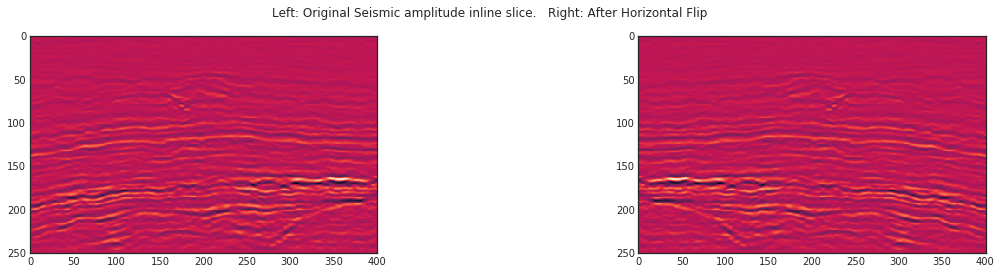

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(20,4))
axs[0].imshow(X_Cube[0,:,:,0].squeeze().T)
axs[1].imshow(X_Cube_horizontal_flip[0,:,:,0].squeeze().T)
#axs[1].imshow(X_Cube_horizontal_vertical_flip[0,:,:,0].squeeze().T)
#axs[2].imshow(X_Cube_vertical_flip[0,:,:,0].squeeze().T)
fig.suptitle("Left: Original Seismic amplitude inline slice.   Right: After Horizontal Flip")

In [0]:
# predict by feeding in the original cube (slicing direction across inlines)
prediction_cube_original = argmax(model.predict(X_Cube), axis = 3)

# predict by feeding in the horizontally flipped cube (slicing direction across inlines)
prediction_cube_horizontal_flipped = argmax(model.predict(X_Cube_horizontal_flip), axis = 3)
prediction_cube_horizontal = np.array([np.flipud(y) for y in prediction_cube_horizontal_flipped]) # re_flip prediction to correct orientation

# predict by feeding in the  original cube (slicing direction across crosslines)
X_cube_rotated = np.rot90(X_Cube, axes=(0,1))
prediction_cube_crosslines_rotated = argmax(model.predict(X_cube_rotated), axis = 3)
prediction_cube_crosslines = np.rot90(prediction_cube_crosslines_rotated, axes=(1,0)) # rotate the cube back to correct orientation

Text(0.5, 0.98, 'First: Ground truth.   Second: prediction from the original seismic amplitude cube (predicted across inlines).   Third: prediction from the original seismic cube (predicted across crosslines).   Fourth: prediction from the horizontaly flipped Seismic cube (predicted across inlines then flipped again to correct orientatation).')

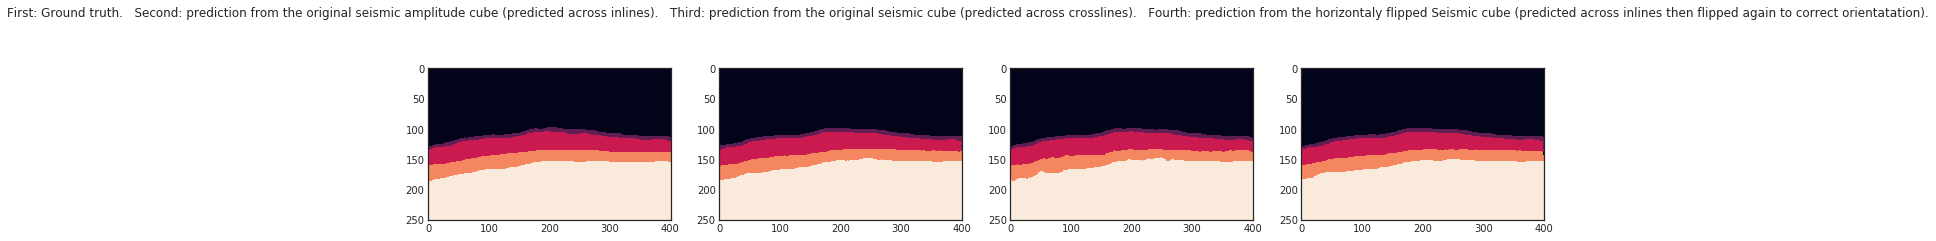

In [0]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))
axs[0].imshow(original_cube_labels_4D[60,:,:,0].squeeze().T)
axs[1].imshow(prediction_cube_original[60].squeeze().T)
axs[2].imshow(prediction_cube_crosslines[60].squeeze().T)
axs[3].imshow(prediction_cube_horizontal[60].squeeze().T)

fig.suptitle("First: Ground truth.   Second: prediction from the original seismic amplitude cube (predicted across inlines).   Third: prediction from the original seismic cube (predicted across crosslines).   Fourth: prediction from the horizontaly flipped Seismic cube (predicted across inlines then flipped again to correct orientatation).")

In [0]:
# Model avarage (by taking the mode the three predictions displqyed above)
all_predictions = np.array([prediction_cube_original[:,:,:], prediction_cube_crosslines[:,:,:], prediction_cube_horizontal[:,:,:]])
combined_prediction = stats.mode(all_predictions)
combined_prediction = combined_prediction[0][0]

In [0]:
# Save prediction
#np.save('/content/gdrive/My Drive/predicted_volume_afterMA_before_CRF2.npy', combined_prediction)

Text(0.5, 0.98, 'Left: Ground truth.     Right: Prediction')

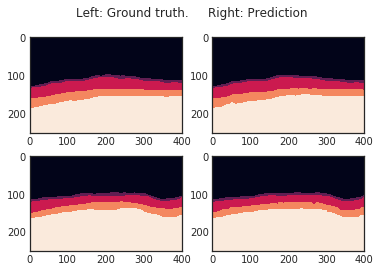

In [0]:
# plot some model avaraged predictions vs ground truths
fig, axs = plt.subplots(2, 2, figsize=(6,4))
axs[0,0].imshow(original_cube_labels_4D[60,:,:,0].squeeze().T)
axs[0,1].imshow(combined_prediction[60].squeeze().T)
axs[1,0].imshow(original_cube_labels_4D[:,330,:,0].squeeze().T)
axs[1,1].imshow(combined_prediction[:,330,:].squeeze().T)
fig.suptitle("Left: Ground truth.     Right: Prediction")

In [0]:
# save predictions
#np.save('/content/gdrive/My Drive/predicted_volume_afterModelAverage_beforeCRF.npy', combined_prediction)

In [0]:
# This is to spare memory so the session doesn't crash
del prediction_cube_original, prediction_cube_horizontal_flipped, prediction_cube_horizontal
del prediction_cube_crosslines_rotated, prediction_cube_crosslines

overall accuracy is  0.9851911438084207
label0 accuracy is  0.998479669255395
label1 accuracy is  0.913617670812943
label2 accuracy is  0.9461735686887939
label3 accuracy is  0.9259465136139471
label4 accuracy is  0.9981370032338909


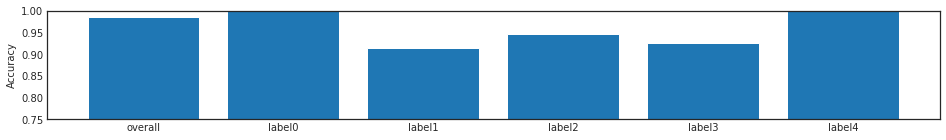

<Figure size 720x4320 with 0 Axes>

In [0]:
# pixelwise accuracy
test_accuracy = test_accuracy_score(combined_prediction, original_cube_labels_4D-1)

Above we see that the accuracy improved slightly from 0.984 we had before model averaging.

In [0]:
#iou accuracy
iou_accuracy(combined_prediction, original_cube_labels_4D[:,:,:,0]-1)

W0828 14:06:32.123743 140180525930368 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:1179: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


[0.92464864]


# Conditional Random Field

CRFs are applied to the FCN output to structure the output space

https://github.com/lucasb-eyer/pydensecrf

In [0]:
# crf library from https://github.com/lucasb-eyer/pydensecrf
!pip install '/content/gdrive/My Drive/pydensecrf'

Processing ./gdrive/My Drive/pydensecrf
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp36-cp36m-linux_x86_64.whl size=2234943 sha256=35159ec1a8ac0a68ea1bbe9fcc1a233116055abe0f1eb610b904a349b1d7490b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tnfmr6tm/wheels/80/c5/63/916bb868352090a8237bc17772193c17f16ee3d29acb7f4396
Successfully built pydensecrf


In [0]:
# combined_prediction = np.load('/content/gdrive/My Drive/FCN Approach/combined_prediction2.npy')

In [0]:
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
%matplotlib inline

In [0]:
def crf(mask_img, sxy, compat):
    """
    Function which returns the labelled image after applying CRF:
    
    mask_img = segmentation map which has been labelled by some technique..
    sxy = theta
    compat = w
    """
    
    
    annotated_label = mask_img[:,:] 
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 5
    
    # Setting up the CRF model
    d = dcrf.DenseCRF2D(mask_img.shape[1], mask_img.shape[0], n_labels)

    # Get unary-potentials
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # Add Pairwise Potentials 
    d.addPairwiseGaussian(sxy=sxy, compat=compat, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

    #Run Inference for 20 steps 
    Q = d.inference(20)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((mask_img.shape[0],mask_img.shape[1]))

Text(0.5, 0.98, 'Left: Ground truth.     Middle: Prediction.    Right: After CRF post-processing')

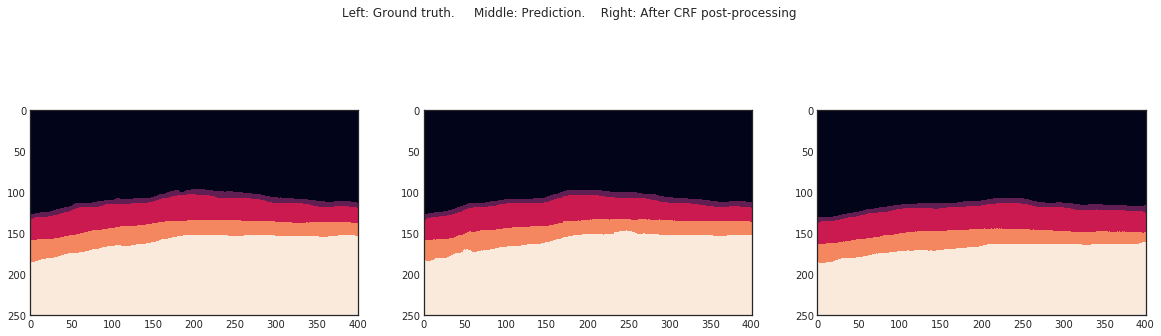

In [0]:
after_crf = crf(combined_prediction[2], (2,2), 6)

fig, axs = plt.subplots(1,3 , figsize=(20,6))
axs[0].imshow(original_cube_labels_4D[60,:,:,0].squeeze().T)
axs[1].imshow(combined_prediction[60].squeeze().T)
axs[2].imshow(after_crf.squeeze().T)
fig.suptitle("Left: Ground truth.     Middle: Prediction.    Right: After CRF post-processing")

In [0]:
# Apply crf to entire cube
CRF_Cube = np.zeros(combined_prediction.shape)

for i in range(combined_prediction.shape[0]):
  crf_smoothed_inline = crf(combined_prediction[i,:,:], (2,2), 6)
  CRF_Cube[i,:,:] = crf_smoothed_inline

for i in range(combined_prediction.shape[1]):
  crf_smoothed_inline = crf(CRF_Cube[:,i,:], (2,2), 6)
  CRF_Cube[:,i,:] = crf_smoothed_inline

In [0]:
# save prediction
#np.save(''/content/gdrive/My Drive/predicted_volume_afterModelAverage_afterCRF.npy'', CRF_Cube)

overall accuracy is  0.9855687107850586
label0 accuracy is  0.998546578676918
label1 accuracy is  0.9137465807137116
label2 accuracy is  0.9492302568179947
label3 accuracy is  0.9262423992962857
label4 accuracy is  0.9981598248324051


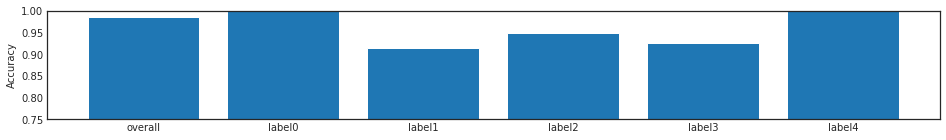

<Figure size 720x4320 with 0 Axes>

In [0]:
# Accuracy after CRF-Smoothing
test_accuracy = test_accuracy_score(CRF_Cube, original_cube_labels_4D-1)

Above we see a slight improvement to the accuracy we had before the CRF post-processing (0.9851).

In [0]:
#iou accuracy
iou_accuracy(CRF_Cube, original_cube_labels_4D[:,:,:,0]-1)

[0.9275249]
